In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
import sklearn.utils
import pickle

from keras.regularizers import l2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence

from google.colab import drive


In [ ]:
# drive.mount('/content/drive')  #uncomment this line to mount google drive only when running in collab

Mounted at /content/drive


In [ ]:
def load_data(video_dir, frame_size=(224, 224), num_frames=20):
    X = []
    y = []
    for label, folder in enumerate(['Foul', 'No Foul']):
        folder_path = os.path.join(video_dir, folder)
        for video_file in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_file)
            video_frames = []
            cap = cv2.VideoCapture(video_path)
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            step = frame_count // num_frames

            for i in range(0, frame_count, step):
                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()
                if ret:
                    frame = cv2.resize(frame, frame_size)
                    if frame is not None:
                        video_frames.append(frame)
                if len(video_frames) >= num_frames:
                    break

            while len(video_frames) < num_frames:
                video_frames.append(frame)

            cap.release()

            # Ensure all frames have the same shape
            video_frames = [f for f in video_frames if f is not None and f.shape == video_frames[0].shape]
            stacked_frames = np.stack(video_frames, axis=0)
            X.append(stacked_frames)
            y.append(label)

    return X, np.array(y)

In [ ]:
video_dir = '/content/drive/MyDrive/Prototype/Dataset' #change this to the path of the dataset folder
frame_size = (224, 224) #change this to the desired frame size
num_frames = 20    #change this to the desired number of frames per video
X, y = load_data(video_dir, frame_size=frame_size, num_frames=num_frames)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
class VideoDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, frame_count, shuffle=True, augment=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.frame_count = frame_count
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()

        self.image_data_gen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            channel_shift_range=30,
            fill_mode='nearest')

    def __len__(self):
        return len(self.X) // self.batch_size

    def __getitem__(self, index):
      # Loop through the dataset when the index is out of range
      index = index % self.__len__()

      batch_X = self.X[index * self.batch_size:(index + 1) * self.batch_size]
      batch_y = self.y[index * self.batch_size:(index + 1) * self.batch_size]

      augmented_batch_X = []

      for video_frames in batch_X:
          if self.augment:
              augmented_frames = self.augment_video(video_frames)
          else:
              augmented_frames = video_frames

          # Ensure all videos have the same number of frames
          if len(augmented_frames) > self.frame_count:
              augmented_frames = augmented_frames[:self.frame_count]
          elif len(augmented_frames) < self.frame_count:
              padding_frames = [np.zeros_like(augmented_frames[0])] * (self.frame_count - len(augmented_frames))
              augmented_frames = np.concatenate((augmented_frames, padding_frames), axis=0)

          X_batch = np.stack(augmented_frames, axis=0)
          augmented_batch_X.append(X_batch)

      if not augmented_batch_X:
          raise ValueError("augmented_batch_X is empty")

      X_batch = np.stack(augmented_batch_X, axis=0)
      y_batch = np.array(batch_y)

      return X_batch, y_batch

    def on_epoch_end(self):
      if self.shuffle:
          indices = np.arange(len(self.X))
          np.random.shuffle(indices)
          self.X = [self.X[i] for i in indices]
          self.y = [self.y[i] for i in indices]

    def augment_video(self, video_frames):
        augmented_frames = []

        for frame in video_frames:
            frame = self.image_data_gen.random_transform(frame)
            augmented_frames.append(frame)

        return augmented_frames

In [ ]:
epochs = 20
batch_size = 10
frame_count = 20

# Create data generators
train_data_gen = VideoDataGenerator(X_train, y_train, batch_size, frame_count, augment=True, shuffle=True)
val_data_gen = VideoDataGenerator(X_val, y_val, batch_size, frame_count, augment=False, shuffle=False)


In [ ]:
def create_model(input_shape, num_classes):
    base_model = InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    # Add layers to the base model
    model = Sequential()
    model.add(TimeDistributed(base_model, input_shape=(num_frames,) + input_shape))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
input_shape = (224, 224, 3) 
num_classes = 2             
model = create_model(input_shape, num_classes)

87910968/87910968 [==============================] - 3s 0us/step


Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 5, 5, 2048)   21802784  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 2048)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               1114624   
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)   

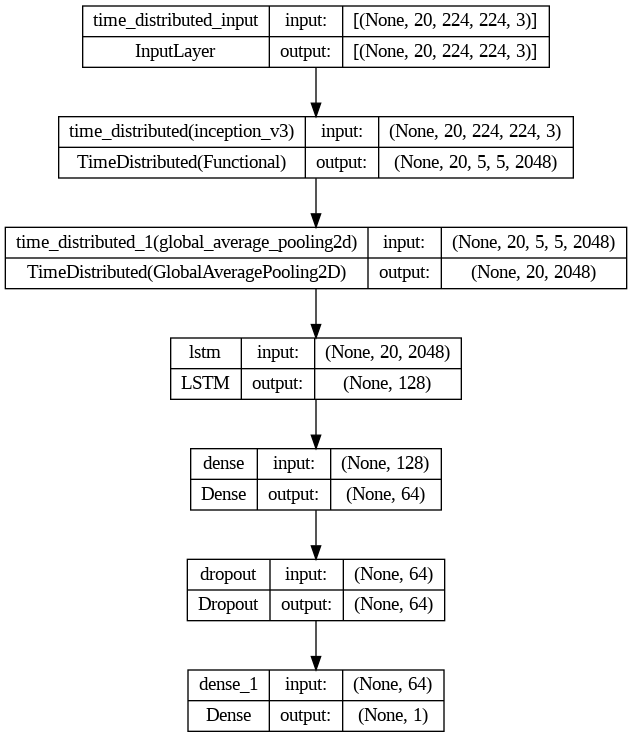

In [ ]:
# Print the model summary and save the model as a PNG image
print("Model Summary:")
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [ ]:
epochs = 20

batch_size = 10
steps_per_epoch = len(X_train) // batch_size

# Train the model
history = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1)

Epoch 1/20
21/21 [==============================] - 83s 3s/step - loss: 55.0088 - accuracy: 0.4762 - val_loss: 50.9693 - val_accuracy: 0.6250
Epoch 2/20
21/21 [==============================] - 57s 3s/step - loss: 40.5402 - accuracy: 0.5095 - val_loss: 19.9427 - val_accuracy: 0.6000
Epoch 3/20
21/21 [==============================] - 58s 3s/step - loss: 56.6943 - accuracy: 0.5476 - val_loss: 25.3168 - val_accuracy: 0.4250
Epoch 4/20
21/21 [==============================] - 58s 3s/step - loss: 45.0288 - accuracy: 0.5048 - val_loss: 12.5778 - val_accuracy: 0.5000
Epoch 5/20
21/21 [==============================] - 58s 3s/step - loss: 45.5026 - accuracy: 0.5810 - val_loss: 4.5681 - val_accuracy: 0.8250
Epoch 6/20
21/21 [==============================] - 59s 3s/step - loss: 50.0212 - accuracy: 0.5190 - val_loss: 35.9524 - val_accuracy: 0.3750
Epoch 7/20
21/21 [==============================] - 59s 3s/step - loss: 40.9737 - accuracy: 0.5524 - val_loss: 12.6166 - val_accuracy: 0.5750
Epoch 8

In [ ]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_data_gen,
    validation_data=val_data_gen,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs // 2,
    verbose=1)

Epoch 1/10
21/21 [==============================] - 67s 3s/step - loss: 23.3764 - accuracy: 0.5524 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 2/10
21/21 [==============================] - 60s 3s/step - loss: 29.9063 - accuracy: 0.5095 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 3/10
21/21 [==============================] - 63s 3s/step - loss: 29.7998 - accuracy: 0.4905 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 4/10
21/21 [==============================] - 60s 3s/step - loss: 28.1732 - accuracy: 0.4952 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 5/10
21/21 [==============================] - 62s 3s/step - loss: 26.9553 - accuracy: 0.5524 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 6/10
21/21 [==============================] - 62s 3s/step - loss: 25.2993 - accuracy: 0.5714 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 7/10
21/21 [==============================] - 65s 3s/step - loss: 28.6299 - accuracy: 0.5429 - val_loss: 7.6821 - val_accuracy: 0.7000
Epoch 8/10
21

In [ ]:
test_data_gen = VideoDataGenerator(X_test, y_test, batch_size, frame_count, augment=False, shuffle=False)

test_loss, test_acc = model.evaluate(test_data_gen, verbose=1)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

4/4 [==============================] - 1s 349ms/step - loss: 4.1529 - accuracy: 0.7750
Test accuracy: 77.50%


In [ ]:
# Save the data to pickle files
with open('X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('X_val.pkl', 'wb') as f:
    pickle.dump(X_val, f)
with open('y_val.pkl', 'wb') as f:
    pickle.dump(y_val, f)
with open('X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

In [ ]:
model.save('/content/drive/MyDrive/punch_classifier_model.h5') #change this to the path of the folder to save the model

In [ ]:
# Load the data from pickle files
with open('X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

2/2 [==============================] - 31s 9s/step
Accuracy: 0.7778

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.77      0.77        22
           1       0.78      0.78      0.78        23

    accuracy                           0.78        45
   macro avg       0.78      0.78      0.78        45
weighted avg       0.78      0.78      0.78        45


Confusion matrix:
[[17  5]
 [ 5 18]]

AUC-ROC: 0.8557

Cohen's Kappa: 0.5553

Matthews Correlation Coefficient: 0.5553


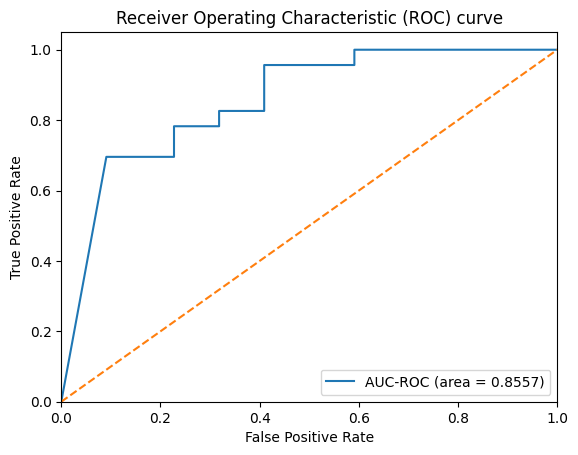

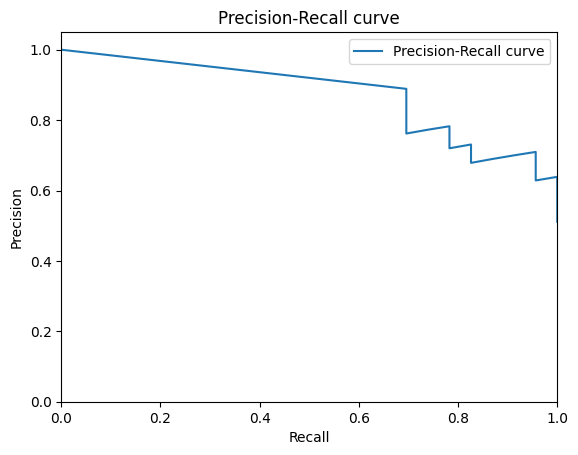

In [ ]:
# Evaluation

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, cohen_kappa_score, matthews_corrcoef)

model_path='/content/drive/MyDrive/punch_classifier_model.h5' #change this to the path of the folder to load the model

def evaluate_model(X_test, y_test, model_path = model_path):
    model = load_model(model_path)
    y_pred = model.predict(np.array(X_test))
    y_pred_classes = (y_pred > 0.5).astype('int32').flatten()

    # Accuracy
    acc = accuracy_score(y_test, y_pred_classes)
    print(f"Accuracy: {acc:.4f}")

    # Classification report
    print("\nClassification report:")
    print(classification_report(y_test, y_pred_classes))

    # Confusion matrix
    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred_classes))

    # AUC-ROC curve
    auc = roc_auc_score(y_test, y_pred)
    print(f"\nAUC-ROC: {auc:.4f}")

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred_classes)
    print(f"\nCohen's Kappa: {kappa:.4f}")

    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"\nMatthews Correlation Coefficient: {mcc:.4f}")

    # Plotting AUC-ROC and Precision-Recall curves
    import matplotlib.pyplot as plt

    # AUC-ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC-ROC (area = {auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.show()

# To evaluate the model, call the function and pass the X_test and y_test datasets
evaluate_model(X_test, y_test)


In [ ]:
# Inference
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

def load_video(video_path, frame_size=(224, 224), num_frames=20):
    video_frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = frame_count // num_frames

    for i in range(0, frame_count, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, frame_size)
            if frame is not None:
                video_frames.append(frame)
        if len(video_frames) >= num_frames:
            break

    while len(video_frames) < num_frames:
        video_frames.append(frame)

    cap.release()
    
    # Ensure all frames have the same shape
    video_frames = [f for f in video_frames if f is not None and f.shape == video_frames[0].shape]
    stacked_frames = np.stack(video_frames, axis=0)

    return np.array([stacked_frames])

def predict_foul(video_path, model_path='/content/drive/MyDrive/punch_classifier_model.h5'):
    model = load_model(model_path)
    video_data = load_video(video_path)
    prediction = model.predict(video_data)[0][0]
    
    if prediction > 0.5:
        return "Foul"
    else:
        return "No Foul"

if __name__ == '__main__':
    video_path = input("Enter the path to the video: ").strip()
    result = predict_foul(video_path)
    print(f"Action in the video is: {result}")


Enter the path to the video: /content/drive/MyDrive/Prototype/TestData/non_foul_51.mp4


1/1 [==============================] - 2s 2s/step
Action in the video is: Foul
